GDP data obtained from [IPEADATA](http://www.ipeadata.gov.br/Default.aspx).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
data = pd.read_csv('./ipeadata[22-09-2019-04-29].csv', sep=';', usecols=[0,1])

In [15]:
data.head()

,Data,"PIB - R$ - Banco Central do Brasil, Boletim, Seção Atividade Econômica (Bacen / Boletim / Ativ. Ec.) - BM12_PIB12"
0,1990.01,"0,2"
1,1990.02,"0,4"
2,1990.03,"0,8"
3,1990.04,"0,7"
4,1990.05,"0,8"


In [16]:
data.columns = ['quarter', 'gdp']

In [18]:
data.set_index('quarter', inplace=True)

In [22]:
data['gdp'] = pd.to_numeric(data.gdp.str.replace(',','.'))

In [23]:
data.head()

,gdp
quarter,
1990.01,0.2
1990.02,0.4
1990.03,0.8
1990.04,0.7
1990.05,0.8


***

The model:

$$
\textrm{GDP}_t = \beta_1 + \beta_2 \textrm{GDP}_{t-1} + u_t
$$

The residuals:

$$
u_t = \displaystyle\sum_{j=1}^{p} \big( \rho_j \cdot u_{t-j} \big) + e_t 
$$

In [31]:
from sklearn.linear_model import LinearRegression

**Breusch-Godfrey LM test**:

$$
\begin{align}
H_0 & : \rho_1 = \rho_2 = ... = \rho_p = 0 \\
H_1 & : \exists\ \rho_j \neq 0,\ j = 1,2,..., p
\end{align}
$$

More info on the test [here](https://en.wikipedia.org/wiki/Breusch%E2%80%93Godfrey_test).

<u>Step 1</u>: Estimate $y_t$ by OLS, save $\hat u_t$:

In [42]:
X = data.gdp.iloc[:-1].values.reshape((-1,1))
y = data.gdp.iloc[1:].values.reshape((-1,1))

In [43]:
linreg = LinearRegression()

In [44]:
linreg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [45]:
print(linreg.intercept_, linreg.coef_)

[1197.99540287] [[1.00234228]]


In [61]:
y_hat = linreg.predict(X)

In [58]:
plt.style.use('ggplot')

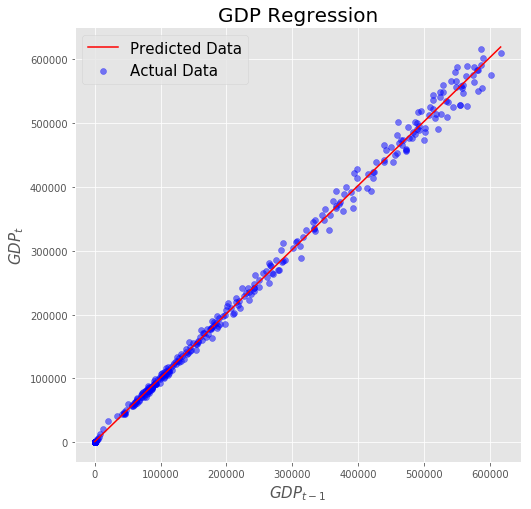

In [62]:
fig, ax = plt.subplots(figsize=(8,8))

ax.set_title('GDP Regression', fontsize=20)

ax.scatter(X, y, alpha=0.5, label='Actual Data', color='blue')
ax.plot(X, y_hat, color='red', lw=1.5, label='Predicted Data')

ax.set_xlabel(r'$GDP_{t-1}$', fontsize=15)
ax.set_ylabel(r'$GDP_t$', fontsize=15)
ax.legend(prop={'size': 15})
plt.show()

In [63]:
u_hat = y - y_hat

In [88]:
# Number of lags
p = 3
# Number of observations
T, _ = X.shape

<u>Step 2</u>: Regress $\hat u_t$ on constant, $\textrm{GDP}_{t-1}$ and $\hat u_{t-1}, ..., \hat u_{t-p}$:

In [83]:
X_resid = X[p:]
y_resid = u_hat[p:]

In [84]:
for i in range(1, p+1):
    u_lag = u_hat[p-i:-i]
    X_resid = np.concatenate((X_resid, u_lag), axis=1)

In [87]:
X_resid.shape

(351, 4)

In [90]:
resid_reg = LinearRegression()

In [91]:
resid_reg.fit(X_resid, y_resid)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [92]:
print(resid_reg.intercept_, resid_reg.coef_)

[-491.24358807] [[ 0.00210706 -0.35455953 -0.37634889 -0.23122662]]


In [93]:
r_squared = resid_reg.score(X_resid, y_resid)

<u>Step 3</u>: Compute the test statistic $(T-p) R^2$, which must follow a $\chi^2$ distribution with $p$ degrees of freedom.

In [95]:
test_stat = (T - p) * r_squared

In [96]:
from scipy.stats import chi2

In [97]:
alpha = 0.05
df = p

In [99]:
chi2_crit = chi2.ppf(q=1-alpha, df=df)

In [100]:
if test_stat > chi2_crit:
    print('REJECT NULL HYPOTHESIS! -> There is serial correlation.')
else:
    print('Failed to reject the hull hypothesis.')

REJECT NULL HYPOTHESIS! -> There is serial correlation.
